# Q1

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
W = 64

image = np.zeros((W, W))
for i in range(W):
    image[i, i] = 1.0  

In [5]:
def dft2(image):
    H, W = image.shape
    F = np.zeros((H, W), dtype=complex)
    for u in range(H):
        for v in range(W):
            sum_val = 0.0
            for x in range(H):
                for y in range(W):
                    sum_val += image[x, y] * np.exp(-2j * np.pi * (u*x + v*y) / W)
            F[u, v] = sum_val
    return F

In [6]:
magnitude = np.abs(dft2(image))

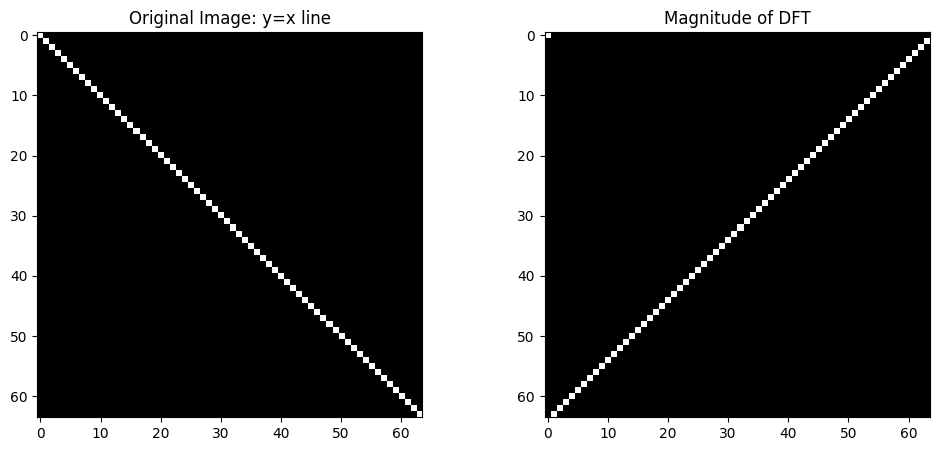

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('Original Image: y=x line')
plt.subplot(1,2,2)
plt.imshow(magnitude, cmap='gray')
plt.title('Magnitude of DFT')
plt.show()

# Q2

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
image = cv2.imread('Q2/noisy.jpg', cv2.IMREAD_GRAYSCALE)

In [3]:
def show(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')

In [4]:
def DFT_1D(signal):
    N = len(signal)
    n = np.arange(N)
    k = n.reshape((N, 1))
    
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, signal)

In [5]:
def IDFT_1D(dft):
    N = len(dft)
    n = np.arange(N)
    k = n.reshape((N, 1))
    
    M = np.exp(2j * np.pi * k * n / N)
    
    return np.dot(M, dft) / N

In [6]:
def DFT_2D(image):
    M, N = image.shape
    dft_rows = np.zeros((M, N), dtype=complex)
    for i in range(M):
        dft_rows[i, :] = DFT_1D(image[i, :])
    
    dft_full = np.zeros((M, N), dtype=complex)
    
    dft_rows_T = dft_rows.T
    for j in range(N):
        dft_full[:, j] = DFT_1D(dft_rows_T[j, :])
    
    return dft_full

In [7]:
def IDFT_2D(dft):
    M, N = dft.shape
    
    idft_rows = np.zeros((M, N), dtype=complex)
    for i in range(M):
        idft_rows[i, :] = IDFT_1D(dft[i, :])
    idft_full = np.zeros((M, N), dtype=complex)
    idft_rows_T = idft_rows.T
    for j in range(N):
        idft_full[:, j] = IDFT_1D(idft_rows_T[j, :])
    
    return np.real(idft_full)

In [8]:
def gaussian_lowpass_filter(shape, D0):
    M, N = shape
    u = np.arange(M) - M // 2
    v = np.arange(N) - N // 2
    
    V, U = np.meshgrid(v, u)
    D_sq = U**2 + V**2
    H = np.exp(-(D_sq) / (2 * (D0**2)))
    
    return H

In [9]:
image_float = image.astype(np.float64)
M, N = image.shape
i, j = np.ogrid[0:M, 0:N]
pre_shifted_image = image_float * ((-1)**(i + j))
dft = DFT_2D(pre_shifted_image)

In [10]:
magnitude = np.abs(dft)
phase = np.angle(dft)
magnitude_display = np.log(magnitude + 1)
D0 = 30
H = gaussian_lowpass_filter(image.shape, D0)
filtered_dft = dft * H

filtered_image = IDFT_2D(filtered_dft)
filtered_image = filtered_image * ((-1)**(i + j))
filtered_image = np.clip(filtered_image, 0, 255).astype(np.uint8)

(np.float64(-0.5), np.float64(254.5), np.float64(105.5), np.float64(-0.5))

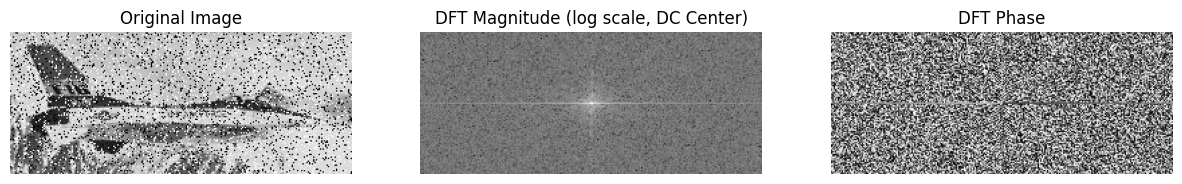

In [16]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(2, 3, 2)

plt.imshow(magnitude_display, cmap='gray')
plt.title('DFT Magnitude (log scale, DC Center)')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(phase, cmap='gray')
plt.title('DFT Phase')
plt.axis('off')

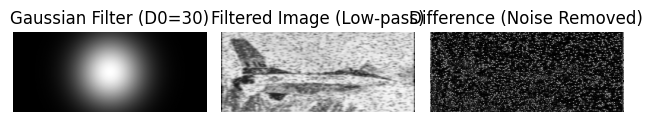

In [ ]:
plt.subplot(2, 3, 4)
plt.imshow(H, cmap='gray')
plt.title(f'Gaussian Filter (D0={D0})')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image (Low-pass)')
plt.axis('off')

plt.subplot(2, 3, 6)

difference = cv2.absdiff(image, filtered_image)
plt.imshow(difference, cmap='gray')
plt.title('Difference (Noise Removed)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Q3

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [20]:
image = cv2.imread('Q3/Lena.png', cv2.IMREAD_GRAYSCALE)

In [21]:
def show(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')

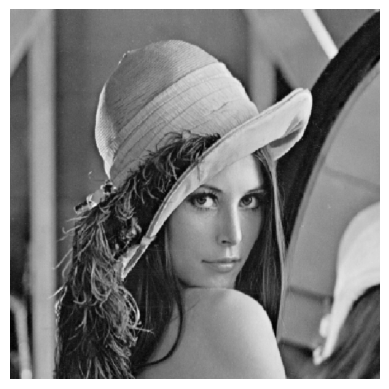

In [22]:
show(image)

In [23]:
def salt_pepper(image, amount):
    noisy = image.copy()
    num_salt = np.ceil(amount * image.size * 0.5)
    num_pepper = np.ceil(amount * image.size * 0.5)
    
    coords = [np.random.randint(0, i-1, int(num_salt)) for i in image.shape]
    noisy[coords[0], coords[1]] = 255
    
    coords = [np.random.randint(0, i-1, int(num_pepper)) for i in image.shape]
    noisy[coords[0], coords[1]] = 0
    
    return noisy


In [24]:
noisy_image = salt_pepper(image, amount=0.05)


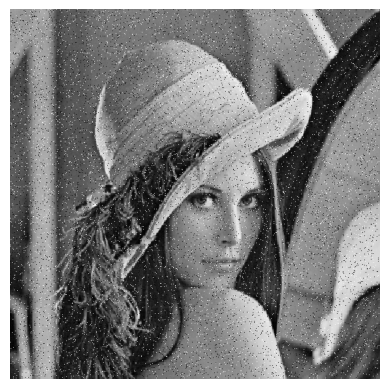

In [25]:
show(noisy_image)

In [26]:
def replicate_padding(image, pad_size=1):
    return np.pad(image, pad_size, mode='edge')

In [27]:
def filter_image(image, kernel_size=3, mode='median'):
    pad = kernel_size // 2
    padded = replicate_padding(image, pad)
    output = np.zeros_like(image)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = padded[i:i+kernel_size, j:j+kernel_size]
            if mode == 'min':
                output[i, j] = np.min(window)
            elif mode == 'max':
                output[i, j] = np.max(window)
            else:
                output[i, j] = np.median(window)
    return output

In [28]:
min_img = filter_image(noisy_image, mode='min')
max_img = filter_image(noisy_image, mode='max')
median_img = filter_image(noisy_image, mode='median')

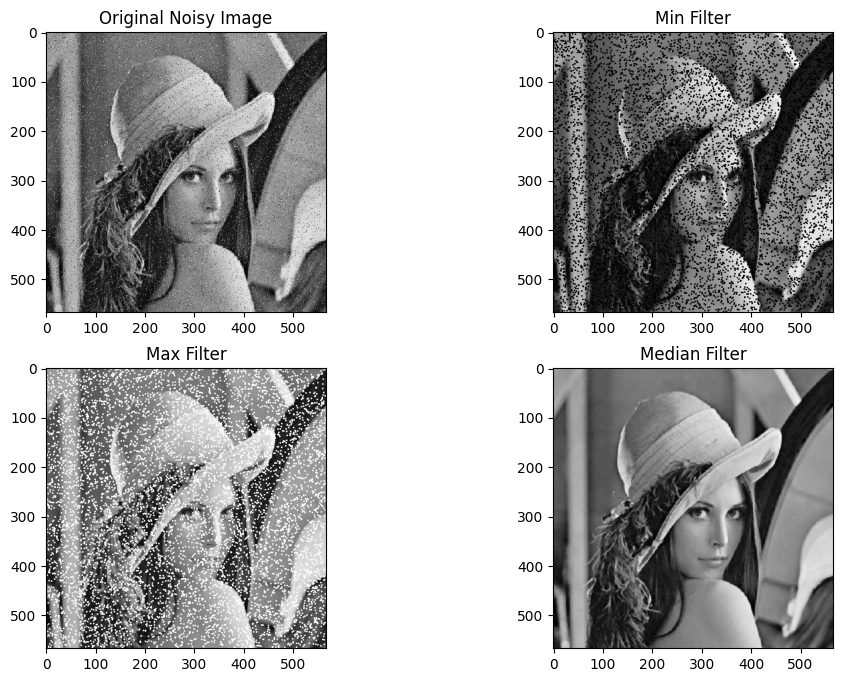

In [29]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.title('Original Noisy Image')
plt.imshow(noisy_image, cmap='gray')
plt.subplot(2,2,2)
plt.title('Min Filter')
plt.imshow(min_img, cmap='gray')
plt.subplot(2,2,3)
plt.title('Max Filter')
plt.imshow(max_img, cmap='gray')
plt.subplot(2,2,4)
plt.title('Median Filter')
plt.imshow(median_img, cmap='gray')
plt.show()

## Analysis of Filters on Salt-and-Pepper Noise


### A) Which filter removes salt-and-pepper noise better?

The **Median** filter performs best at removing salt-and-pepper noise.  

- Reason: The median filter selects the middle value of the pixels in the 3×3 window instead of averaging or taking min/max.  

- As a result, noisy pixels (0 or 255) that are far from the neighboring values have little effect on the output and are effectively removed.  


### B) Which filter blurs edges more?

The **Min** and **Max** filters blur edges more.  

- The **Min** filter replaces a pixel with the smallest value in the window, which darkens bright edges.  

- The **Max** filter replaces a pixel with the largest value in the window, which brightens dark edges.  

- In general, the Median filter preserves edges better and causes less blurring than Min or Max filters.  


### C) Does combining Min and Max filters in sequence improve or worsen the result? Why?

Combining **Min → Max** or **Max → Min** usually **worsens the result**.  

- Reason:  

  - Applying Min pushes pixels toward the darkest value in the window.  

  - Applying Max afterward pushes pixels toward the brightest value in the window.  

- This combination increases blurring and removes fine details, and it does not fully eliminate noise.  

- In other words, this method reduces noise but significantly blurs edges and details, so it generally performs **worse than the Median filter**.


# Q4

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [31]:
image = cv2.imread('Q4/moon.jpg', cv2.IMREAD_GRAYSCALE)

In [32]:
def Show(image, title):
    plt.title(title)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

In [33]:
Laplacian = np.array([[-1, -1, -1],
                        [-1, 8, -1],
                        [-1, -1, -1]])

In [34]:
def LaplacianFilter(image):


    padded = np.pad(image, pad_width=1, mode='reflect')
    output = np.zeros_like(image, dtype=np.int32)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i: i + 3, j: j + 3]
            output[i, j] = np.sum(Laplacian * region)
    output = np.clip(output, 0, 255).astype(np.uint8)
    
    return output


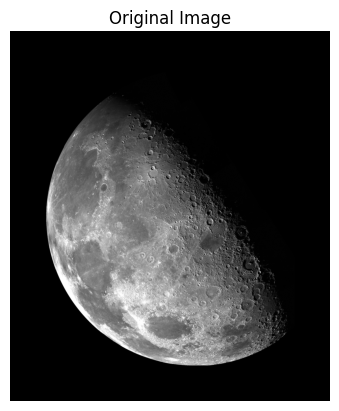

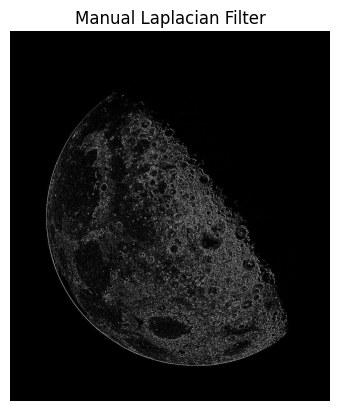

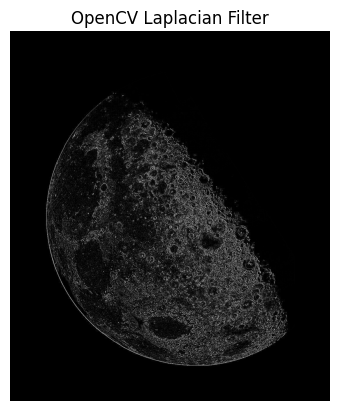

In [35]:
Show(image, "Original Image")
plt.show()

Show(LaplacianFilter(image), "Manual Laplacian Filter")
plt.show()

Show(cv2.filter2D(image, -1, Laplacian), "OpenCV Laplacian Filter")
plt.show()
